# Load the necessary package/library

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the file and change the formate of columns (remove spaces)

In [16]:
file1= pd.read_excel("PSM example file.xlsx")
file1.columns= ['Peptide', 'P', 'Mass', 'Length', 'ppm', 'm/z', 'Z', 'RT', 'Area',
       'Fraction', 'Id', 'Rep', 'Scan', 'from_Chimera', 'Source_File',
       'Accession', 'PTM', 'AScore', 'Found_By', 'Sample_Group']

In [17]:
file1.shape

(17602, 20)

# Convert the PSM file to matrix based on the condition

In [18]:
file=file1[['Peptide','Area','Source_File']]
file.Area=file.Area.astype(dtype=float)
file.set_index("Peptide",inplace=True)
file=file.pivot_table(columns="Source_File",index="Peptide",values="Area")

In [19]:
file.shape

(4724, 20)

# Change and arrange the column names

In [20]:
file.columns= ["XylemSap_rep2","XylemSap_rep3","XylemSap_rep4","XylemSap_rep5","XylemSap_rep1","Roots_ECM1","Roots_ECM2","Roots_ECM3","LB1","LB2","LB3","Leaves_no_ECM1","Leaves_no_ECM2","Leaves_no_ECM3","Leaves_ECM1","Leaves_ECM2","Leaves_ECM3","Roots_no_ECM1","Roots_no_ECM2","Roots_no_ECM3"]

In [21]:
file=file[['XylemSap_rep1','XylemSap_rep2', 'XylemSap_rep3', 'XylemSap_rep4', 'XylemSap_rep5',
       'Roots_no_ECM1','Roots_no_ECM2', 'Roots_no_ECM3', 'Roots_ECM1', 'Roots_ECM2', 'Roots_ECM3', 'LB1', 'LB2',
       'LB3', 'Leaves_no_ECM1', 'Leaves_no_ECM2', 'Leaves_no_ECM3',
       'Leaves_ECM1', 'Leaves_ECM2', 'Leaves_ECM3']]

In [12]:
file.to_csv("8_7_all_matrix.csv")

# Only kept the data with at least 2/3 or 4/5 peptide present in any condition

In [22]:
newDF= file
peptides=[]
#newDFExp1=newDF[newDF.iloc[:,0:5].count(axis=1) > 3]
#peptides+=list(newDFExp1.index)
newDFExp2=newDF[newDF.iloc[:,5:8].count(axis=1) > 1]
peptides+=list(newDFExp2.index)
newDFExp3=newDF[newDF.iloc[:,8:11].count(axis=1) > 1]
peptides+=list(newDFExp3.index)
newDFExp4=newDF[newDF.iloc[:,11:14].count(axis=1) > 1]
peptides+=list(newDFExp4.index)
#newDFExp5=newDF[newDF.iloc[:,14:17].count(axis=1) > 1]
#peptides+=list(newDFExp5.index)
#newDFExp6=newDF[newDF.iloc[:,17:21].count(axis=1) > 1]
#peptides+=list(newDFExp6.index)

In [23]:
newDF2 = newDF.reset_index()
newDF3=newDF2[newDF2['Peptide'].isin(peptides)]
newDF3.set_index('Peptide',inplace=True)
file=newDF3
file.fillna(1,inplace=True)
file=np.log2(file)

In [24]:
file.shape

(1467, 20)

In [9]:
file.to_csv("8_7_no_peptide_filtered.csv")

In [68]:
"""Unquote the lines below to visualize the file in heatmap"""
#fig= sns.clustermap(file, cmap='BuGn',col_cluster=False)
#fig.ax_heatmap.set_yticks([]);

'Unquote the lines below to visualize the file in heatmap'

# T-test in Root ECM vs Root no ECM and Leave ECM vs Leave no ECM

In [10]:
from scipy.stats import ttest_ind
def ttest(df_X,condition1,condition2,sample_source):
    index=[]
    t_stat=[]
    p_value=[]
    for a in df_X.index:
        (t_statistic,p_values)=ttest_ind(condition1.loc[a],condition2.loc[a])
        index.append(a)
        t_stat.append(t_statistic)
        p_value.append(p_values)
    ttest=pd.DataFrame(index)
    ttest["t_stat_"+sample_source]=t_stat
    ttest["P_values_"+sample_source]=p_value
    ttest.columns=["Peptide", 't_stat_'+sample_source, 'P_values_'+sample_source]
    return ttest
def conditions(file, factor):
    conditions=file.loc[:,file.columns.str.contains(factor)]
    return conditions 

In [11]:
leave_ECM=conditions(file,"Leaves_ECM")
leave_no_ECM=conditions(file,"Leaves_no_ECM")
Root_ECM=conditions(file,"Roots_ECM")
Root_no_ECM=conditions(file,"Roots_no_ECM")

In [12]:
ttest1=ttest(file,leave_ECM, leave_no_ECM,sample_source="Leave")
ttest2=ttest(file,Root_ECM, Root_no_ECM,sample_source="Root")

C:\Users\himsh\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\himsh\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\himsh\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [13]:
ttest2.to_csv("8_7_ttest_result.csv")

# Calculate the fold change in ECM vs no ECM in different samples

In [72]:
def fold_change(df_X,df_Y,axis):
    fold_change=(df_X.mean(axis=axis))-(df_Y.mean(axis=axis))
    fold_change=pd.DataFrame(fold_change)
    fold_change.columns=["Fold"]
    return fold_change
def significant_withfold_change(df_X,df_foldchange,p_value_Colname,p_value, on):#df_X is ttest result
    sig=df_X.dropna()
    sig=sig.loc[(sig[p_value_Colname]<p_value)]
    fold_change=df_foldchange
    sig_foldchange=sig.merge(fold_change, on=on, how="inner")
    return sig_foldchange 
def splitcolumn(df, delimiter, col_name):
    Acc_list=df[col_name].str.split(delimiter)
    Acc_list.dropna(inplace=True)
    Accession=[]
    for value in Acc_list:
        for sub_value in value:
            Accession.append(sub_value)
    file=pd.DataFrame(Accession)
    return file
def peptide_to_protein(df_X,sample_source,merge_in):
    Access=df_X.loc[df_X.Sample_Group.str.contains(sample_source)]
    Access=Access[['Peptide','Accession']]
    Access=Access.drop_duplicates()
    Access= Access.set_index("Peptide")
    Access=merge_in.merge(Access, on="Peptide",how="left")
    return Access

In [148]:
leave_fc=fold_change(leave_ECM,leave_no_ECM,axis=1)
Root_fc=fold_change(Root_ECM,Root_no_ECM,axis=1)
leave_fold_change=significant_withfold_change(ttest1,leave_fc,p_value_Colname="P_values_Leave",p_value=0.05,on="Peptide")
Root_fold_change=significant_withfold_change(ttest2,Root_fc,p_value_Colname="P_values_Root",p_value=0.05,on="Peptide")

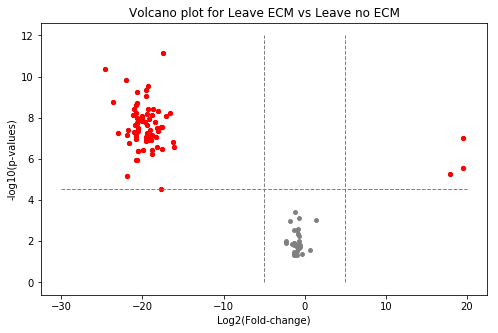

In [149]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(leave_fold_change.Fold,-np.log10(leave_fold_change.P_values_Leave),s=15, color='gray')
ax.scatter(leave_fold_change_2.Fold,-np.log10(leave_fold_change_2.P_values_Leave),s=18, color='red')
ax.plot([-5,-5],[0,12],"k--",lw=1,color="gray")
ax.plot([5,5],[0,12],"k--",lw=1,color="gray")
ax.plot([-30,20],[-np.log10(leave_fold_change_2.P_values_Leave.max()),-np.log10(leave_fold_change_2.P_values_Leave.max())],"k--",lw=1,color="gray")
ax.set_ylabel('-log10(p-values)')
ax.set_xlabel('Log2(Fold-change)')
ax.set_title('Volcano plot for Leave ECM vs Leave no ECM');

# Filtered the peptide with more than (X) fold change

In [86]:
leave_fold_change_2=leave_fold_change.loc[leave_fold_change.Fold.abs()>5] #change the fold change value accordingly 
Root_fold_change_2=Root_fold_change.loc[Root_fold_change.Fold.abs()>5]

# Map the peptide to Accession for each sample source

In [128]:
leave_accession_foldchange=peptide_to_protein(file1,"Leave",leave_fold_change)
Root_accession_foldchange=peptide_to_protein(file1,"Root",Root_fold_change)

In [129]:
leave_accession_foldchange.to_csv("Leave_foldchange_ECMvsnoECM_with_fc.csv")
Root_accession_foldchange.to_csv("Root_foldchange_ECMvsnoECM_with_fc.csv")

# Significant peptide for both T-test

In [130]:
combine=ttest1.merge(ttest2, on="Peptide",how="outer")
combine=combine.set_index("Peptide")
combine=combine.dropna(how="all")
sig=combine.loc[(combine.P_values_Leave<0.05)|(combine.P_values_Root<0.05)]
sig=sig.merge(file,on="Peptide", how="left")
sig=sig[['XylemSap_rep1', 'XylemSap_rep2', 'XylemSap_rep3', 'XylemSap_rep4','XylemSap_rep5', 'Roots_no_ECM1', 'Roots_no_ECM2', 'Roots_no_ECM3','Roots_ECM1', 'Roots_ECM2', 'Roots_ECM3', 'LB1', 'LB2', 'LB3','Leaves_no_ECM1', 'Leaves_no_ECM2', 'Leaves_no_ECM3', 'Leaves_ECM1','Leaves_ECM2', 'Leaves_ECM3']]

# Visualization of Significant peptide

In [17]:
"""Unquote the lines to plot heatmap"""
#fig= sns.clustermap(sig, cmap='BuGn',col_cluster=False, vmax=25,method="ward")
#fig.ax_heatmap.set_yticks([])
#fig.ax_heatmap.set_title("Heatmap of t-test significant peptides")
#fig.savefig("Heatmap of t-test.png")

'Unquote the lines to plot heatmap'

# Mapping all significant Peptide to Accession

In [19]:
allsig_withaccession=sig.merge(file1, on="Peptide", how="left")
allsig_withaccession=allsig_withaccession.reset_index()
#allsig_withaccession.to_csv("pepwithaccession.csv")
"""unquote the last line to save the file"""

'unquote the last line to save the file'